In [1]:
import numpy as np
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time, sys
import pickle
from scipy.io import savemat, loadmat
import torch
import torch.nn as nn

In [2]:
# Choose Re=1000 or Re=100
Re=10000

In [3]:
# choose # of DEIM basis file name
if Re==10000:
    file_name="./data/snapshot_full_high_Re.p"
    file_name_inter="./data/snapshot_full_inter_high_Re.p"
    file_name_r_tilde='./data/snapshot_r_tilde_high_Re_batch_240.p'
elif Re==100:
    file_name="./data/snapshot_full_low_Re.p"
    file_name_inter="./data/snapshot_full_inter_low_Re.p"
    file_name_r_tilde='./data/snapshot_r_tilde_low_Re_batch_240.p'
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))

In [4]:
# Set parameters
if Re==10000:
    nx=60
    ny=60
    nt=1500
elif Re==100:
    nx=60
    ny=60
    nt=1500
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))
    
nxy=(nx-2)*(ny-2)
dx=1/(nx-1)
dy=1/(ny-1)
dt=2/nt

I=sp.eye(nxy,format='csr')

# full indicies, free indicies, fixed indicies
[xv,yv]=np.meshgrid(np.linspace(0,1,nx),np.linspace(0,1,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
free_multi_index=(multi_index_j[1:-1,1:-1].flatten(),multi_index_i[1:-1,1:-1].flatten())
x0_multi_index=(multi_index_j[1:-1,0].flatten(),multi_index_i[1:-1,0].flatten())
x1_multi_index=(multi_index_j[1:-1,-1].flatten(),multi_index_i[1:-1,-1].flatten())
y0_multi_index=(multi_index_j[0,1:-1].flatten(),multi_index_i[0,1:-1].flatten())
y1_multi_index=(multi_index_j[-1,1:-1].flatten(),multi_index_i[-1,1:-1].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
free_raveled_indicies=np.ravel_multi_index(free_multi_index,dims)
x0_raveled_indicies=np.ravel_multi_index(x0_multi_index,dims)
x1_raveled_indicies=np.ravel_multi_index(x1_multi_index,dims)
x01_raveled_indicies=np.concatenate((x0_raveled_indicies,x1_raveled_indicies))
y0_raveled_indicies=np.ravel_multi_index(y0_multi_index,dims)
y1_raveled_indicies=np.ravel_multi_index(y1_multi_index,dims)
y01_raveled_indicies=np.concatenate((y0_raveled_indicies,y1_raveled_indicies))
fixed_raveled_indicies=np.setdiff1d(full_raveled_indicies,free_raveled_indicies)

# boundary one-hot vector
x0_one_hot=np.eye(nx-2)[0]
y0_one_hot=np.eye(ny-2)[0]
x1_one_hot=np.eye(nx-2)[-1]
y1_one_hot=np.eye(ny-2)[-1]

# inner grid
inner_multi_index_i,inner_multi_index_j=np.meshgrid(np.arange(nx-2),np.arange(ny-2),indexing='xy')
inner_x_multi_index=(np.concatenate((inner_multi_index_j[:,0].flatten(),inner_multi_index_j[:,-1].flatten())),
                     np.concatenate((inner_multi_index_i[:,0].flatten(),inner_multi_index_i[:,-1].flatten())))
inner_y_multi_index=(np.concatenate((inner_multi_index_j[0,:].flatten(),inner_multi_index_j[-1,:].flatten())),
                     np.concatenate((inner_multi_index_i[0,:].flatten(),inner_multi_index_i[-1,:].flatten())))

inner_dims=(ny-2,nx-2)
inner_x_raveled_indicies=np.ravel_multi_index(inner_x_multi_index,inner_dims)
inner_y_raveled_indicies=np.ravel_multi_index(inner_y_multi_index,inner_dims)

In [5]:
# first order derivative
# central
Mb=sp.diags([np.ones(nx-2),-np.ones(nx-2)],[0,-1],(nx-2,nx-2))
M=sp.kron(sp.eye(ny-2),Mb,format="csr")

Ib=sp.eye(nx-2)
N=sp.kron(sp.diags([np.ones(ny-2),-np.ones(ny-2)],[0,-1],(ny-2,ny-2)),Ib,format="csr")

# laplacian operator
Dxb=sp.diags([-2*np.ones(nx-2),np.ones(nx-2),np.ones(nx-2)],[0,-1,1],(nx-2,nx-2))
Dx=sp.kron(sp.eye(ny-2),Dxb,format="csr")

Ib=sp.eye(nx-2)
Dy=sp.kron(sp.diags([-2*np.ones(ny-2),np.ones(ny-2),np.ones(ny-2)],[0,-1,1],(ny-2,ny-2)),Ib,format="csr")

In [6]:
if Re==10000:
    file_name_AE="./model/AE_high_Re_v3_batch_240.p"
    latent_dim=5
elif Re==100:
    file_name_AE="./model/AE_low_Re_v3_batch_240.p"
    latent_dim=5
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))

AE = pickle.load(open(file_name_AE,'rb'))

en_wu1=AE['en_wu1']
en_bu1=AE['en_bu1']
en_wu2=AE['en_wu2']
de_wu1=AE['de_wu1']
de_bu1=AE['de_bu1']
de_wu2=AE['de_wu2']
de_wu1T=AE['de_wu1T']
de_wu2T=AE['de_wu2T']
de_wu2_sp=AE['de_wu2_sp']
de_wu2T_sp=AE['de_wu2T_sp']
u_ref=AE['u_ref']

en_wv1=AE['en_wv1']
en_bv1=AE['en_bv1']
en_wv2=AE['en_wv2']
de_wv1=AE['de_wv1']
de_bv1=AE['de_bv1']
de_wv2=AE['de_wv2']
de_wv1T=AE['de_wv1T']
de_wv2T=AE['de_wv2T']
de_wv2_sp=AE['de_wv2_sp']
de_wv2T_sp=AE['de_wv2T_sp']
v_ref=AE['v_ref']

In [7]:
M=M.astype('float32')
N=N.astype('float32')

Dx=Dx.astype('float32')
Dy=Dy.astype('float32')

MT=M.T
NT=N.T

Mu_ref=M.dot(u_ref)
Nu_ref=N.dot(u_ref)
Mv_ref=M.dot(v_ref)
Nv_ref=N.dot(v_ref)

Dxu_ref=Dx.dot(u_ref)
Dyu_ref=Dy.dot(u_ref)
Dxv_ref=Dx.dot(v_ref)
Dyv_ref=Dy.dot(v_ref)

In [8]:
def sigmoid_np(input):
    return (1.0/(1.0+np.exp(-input))).astype('float32')

def encoder_u_np_forward(x):
    z1 = en_wu1.dot(x) + en_bu1
    a1 = sigmoid_np(z1)
    y = en_wu2.dot(a1)   
    return y

def decoder_u_np_forward(x):
    z1 = de_wu1.dot(x) + de_bu1
    a1 = sigmoid_np(z1)
    y = de_wu2.dot(a1)  
    return y

def decoder_u_sp_forward(x):
    z1 = de_wu1.dot(x) + de_bu1
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(de_wu2_sp,a1)
    return y

def encoder_v_np_forward(x):
    z1 = en_wv1.dot(x) + en_bv1
    a1 = sigmoid_np(z1)
    y = en_wv2.dot(a1)   
    return y

def decoder_v_np_forward(x):
    z1 = de_wv1.dot(x) + de_bv1
    a1 = sigmoid_np(z1)
    y = de_wv2.dot(a1)   
    return y

def decoder_v_sp_forward(x):
    z1 = de_wv1.dot(x) + de_bv1
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(de_wv2_sp,a1)
    return y

def decoder_u_np_forward_backwardT(x):
    z1 = de_wu1.dot(x) + de_bu1
    a1 = sigmoid_np(z1)
    y = de_wu2.dot(a1)

    dout = de_wu1T
    dout = (a1*(1-a1))*dout
    dydxT = dout.dot(de_wu2T)   
    return y,dydxT

def decoder_u_sp_forward_backwardT(x):
    z1 = de_wu1.dot(x) + de_bu1
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(de_wu2_sp,a1)

    dout = de_wu1T
    dout = (a1*(1-a1))*dout
    dydxT = sp.csr_matrix.dot(dout,de_wu2T_sp)
    return y,dydxT

def decoder_v_np_forward_backwardT(x):
    z1 = de_wv1.dot(x) + de_bv1
    a1 = sigmoid_np(z1)
    y = de_wv2.dot(a1)

    dout = de_wv1T
    dout = (a1*(1-a1))*dout
    dydxT = dout.dot(de_wv2T)   
    return y,dydxT

def decoder_v_sp_forward_backwardT(x):
    z1 = de_wv1.dot(x) + de_bv1
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(de_wv2_sp,a1)

    dout = de_wv1T
    dout = (a1*(1-a1))*dout
    dydxT = sp.csr_matrix.dot(dout,de_wv2T_sp)
    return y,dydxT

In [9]:
def DEIM(phi_f, nfeval=None):
    
    ninf=np.NINF
    n,m=np.shape(phi_f)
    if nfeval==None:
        nfeval=m
        
    if nfeval<m:
        print("ill-posed\n")
        print("set # sampling equal to # modes")
        nfeval=m
        
    div,mod=np.divmod(nfeval,m)
    
    I=np.eye(n)
    
    l=0
    ns=div+mod
    u=np.reshape(phi_f[:,l],(n,1))
    p=np.argsort(-np.abs(u),axis=0,kind='stable')[:ns]
#     p=np.argmax(np.abs(u)) # when ns=1
    ep=np.reshape(I[:,p],(n,ns))
    U=u
    P=ep

    ns=div
    for l in range(1,m):
        u=np.reshape(phi_f[:,l],(n,1))
        PT=np.transpose(P)
        c=np.linalg.lstsq(PT@U,PT@u,rcond=None)[0]
        r=np.abs(u-U@c)
        r[p]=ninf
        p=np.append(p,np.argsort(-r,axis=0,kind='stable')[:ns]) # ns!=1
        ep=np.reshape(I[:,p[-ns:]],(n,ns))
        U=np.concatenate((U,u),axis=1)
        P=np.concatenate((P,ep),axis=1)
        
    return p

In [10]:
# load sanpshots
# snapshot: just full order solution
# temp=pickle.load(open(file_name,'rb'))
# DEIM_snapshot={'u':temp['u'][:,free_raveled_indicies],'v':temp['v'][:,free_raveled_indicies]}

# snapshot: full order solution including intermediate values
# DEIM_snapshot=pickle.load(open(file_name_inter,'rb'))

# snapshot: residual tilde during NM-ROM (LSPG)
# DEIM_snapshot=pickle.load(open(file_name_r_tilde,'rb'))

# snapshot_u=DEIM_snapshot['u']
# snapshot_v=DEIM_snapshot['v']

# do svd decomposition
# U_u,S_u,V_uT=np.linalg.svd(snapshot_u.T,full_matrices=False)
# U_v,S_v,V_vT=np.linalg.svd(snapshot_v.T,full_matrices=False)
U=pickle.load(open('./model/NMROM_residual_basis.p','rb'))
U_u=U['U_u']
U_v=U['U_v']


amp=0.85


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2517.5139989852905 sec

Best case is
# of residual basis: 47
# of residual sampes: 59

Time elapsed: 20.219000339508057 sec
average relative error of u: 3.8239694437340157%
average relative error of v: 4.224078599923%
maximum relative error of u: 6.2745247701224525%
maximum relative error of v: 7.639043630918002%
maximum relative error: 7.639043630918002%


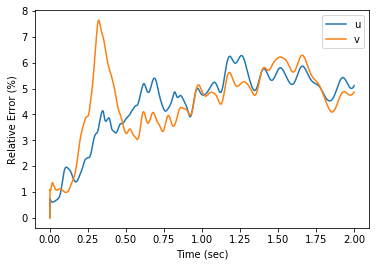


------------------------------------------------------------------------

amp=0.86


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2888.94500041008 sec

Best case is
# of residual basis: 50
# of residual sampes: 50

Time elapsed: 19.567999601364136 sec
average relative error of u: 2.094188668677662%
average relative error of v: 2.1524585763620716%
maximum relative error of u: 3.2367067754836145%
maximum relative error of v: 3.3830714406114906%
maximum relative error: 3.3830714406114906%


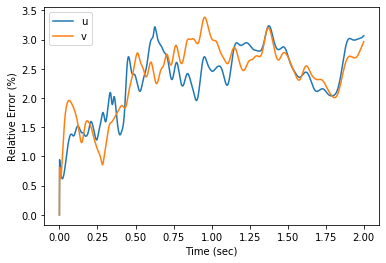


------------------------------------------------------------------------

amp=0.87


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2787.03999710083 sec

Best case is
# of residual basis: 45
# of residual sampes: 45

Time elapsed: 16.22500228881836 sec
average relative error of u: 1.6974211885607489%
average relative error of v: 1.2989621005236707%
maximum relative error of u: 2.9434052303425657%
maximum relative error of v: 2.508846763313618%
maximum relative error: 2.9434052303425657%


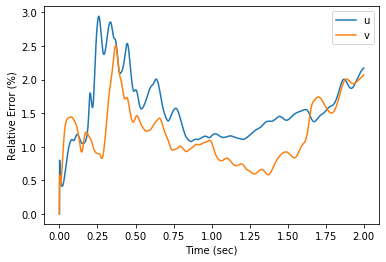


------------------------------------------------------------------------

amp=0.88


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2843.276778459549 sec

Best case is
# of residual basis: 49
# of residual sampes: 50

Time elapsed: 13.885969877243042 sec
average relative error of u: 1.029437979362655%
average relative error of v: 1.1504715326805923%
maximum relative error of u: 1.907985032671375%
maximum relative error of v: 1.7528963546995304%
maximum relative error: 1.907985032671375%


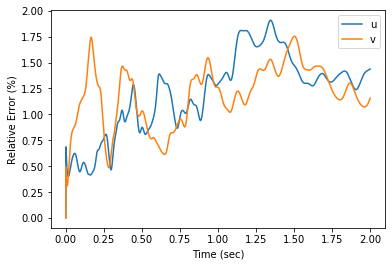


------------------------------------------------------------------------

amp=0.89


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2590.235997200012 sec

Best case is
# of residual basis: 52
# of residual sampes: 52

Time elapsed: 14.20397424697876 sec
average relative error of u: 0.7542334648922747%
average relative error of v: 1.309124185022161%
maximum relative error of u: 1.4183807746383963%
maximum relative error of v: 2.5058877420147714%
maximum relative error: 2.5058877420147714%


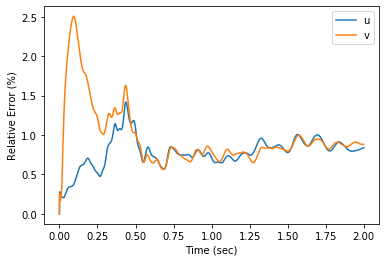


------------------------------------------------------------------------

amp=0.9


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2818.4189970493317 sec

Best case is
# of residual basis: 53
# of residual sampes: 57

Time elapsed: 14.31597089767456 sec
average relative error of u: 0.4235672013329579%
average relative error of v: 0.6869259581914775%
maximum relative error of u: 0.9767834978067145%
maximum relative error of v: 1.2785532682284426%
maximum relative error: 1.2785532682284426%


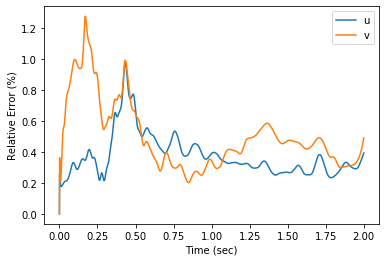


------------------------------------------------------------------------

amp=0.91


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2956.232999563217 sec

Best case is
# of residual basis: 59
# of residual sampes: 59

Time elapsed: 14.487970352172852 sec
average relative error of u: 0.40168130248955825%
average relative error of v: 0.5006293992999349%
maximum relative error of u: 0.7349844014467669%
maximum relative error of v: 0.8120671120283642%
maximum relative error: 0.8120671120283642%


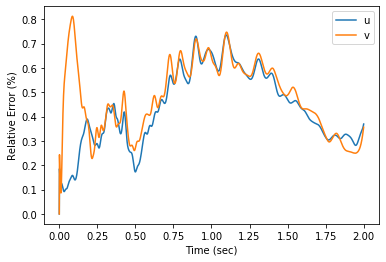


------------------------------------------------------------------------

amp=0.92


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2965.334000110626 sec

Best case is
# of residual basis: 55
# of residual sampes: 58

Time elapsed: 14.413971185684204 sec
average relative error of u: 0.3418412002577855%
average relative error of v: 0.30900650057190304%
maximum relative error of u: 0.6220181935488333%
maximum relative error of v: 0.6210283814438945%
maximum relative error: 0.6220181935488333%


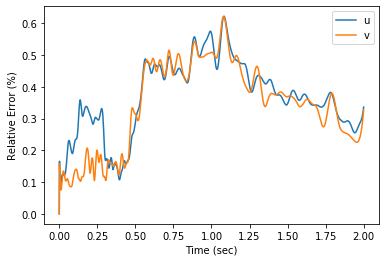


------------------------------------------------------------------------

amp=0.93


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2890.5099968910217 sec

Best case is
# of residual basis: 51
# of residual sampes: 54

Time elapsed: 14.437971115112305 sec
average relative error of u: 0.408266705541792%
average relative error of v: 0.24998885126393602%
maximum relative error of u: 0.6604944004065444%
maximum relative error of v: 0.5772855863849206%
maximum relative error: 0.6604944004065444%


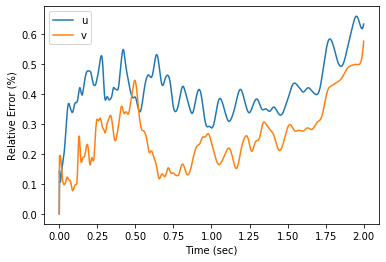


------------------------------------------------------------------------

amp=0.94


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2858.5240004062653 sec

Best case is
# of residual basis: 54
# of residual sampes: 57

Time elapsed: 14.324969053268433 sec
average relative error of u: 0.5301845329957725%
average relative error of v: 0.34662061334315974%
maximum relative error of u: 0.8416105575209671%
maximum relative error of v: 0.7049060722173215%
maximum relative error: 0.8416105575209671%


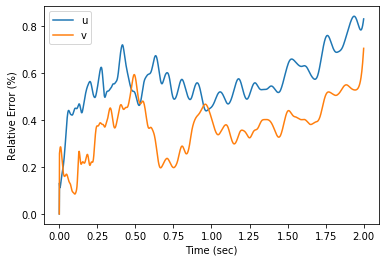


------------------------------------------------------------------------

amp=0.95


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2852.7549979686737 sec

Best case is
# of residual basis: 55
# of residual sampes: 58

Time elapsed: 14.103969097137451 sec
average relative error of u: 0.5393363373977121%
average relative error of v: 0.3743468522335162%
maximum relative error of u: 0.8101215729861431%
maximum relative error of v: 0.6632195448552827%
maximum relative error: 0.8101215729861431%


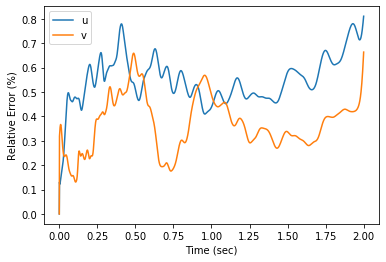


------------------------------------------------------------------------

amp=0.96


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2766.6159946918488 sec

Best case is
# of residual basis: 55
# of residual sampes: 58

Time elapsed: 14.29396390914917 sec
average relative error of u: 0.5236878789950492%
average relative error of v: 0.41629891382712736%
maximum relative error of u: 0.8080662471398921%
maximum relative error of v: 0.7026490941823917%
maximum relative error: 0.8080662471398921%


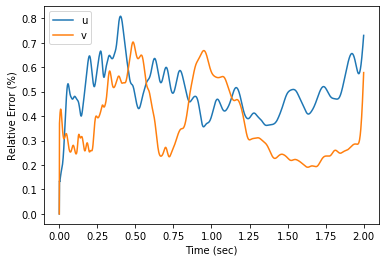


------------------------------------------------------------------------

amp=0.97


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2752.7459959983826 sec

Best case is
# of residual basis: 54
# of residual sampes: 57

Time elapsed: 14.328003644943237 sec
average relative error of u: 0.5147054314012885%
average relative error of v: 0.48320865874058777%
maximum relative error of u: 0.8225725939544645%
maximum relative error of v: 0.7676952068654753%
maximum relative error: 0.8225725939544645%


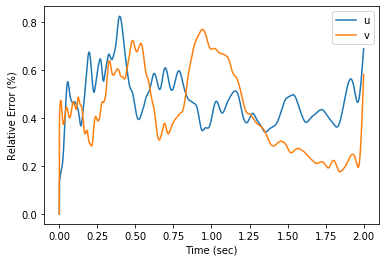


------------------------------------------------------------------------

amp=0.98


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2725.513998270035 sec

Best case is
# of residual basis: 52
# of residual sampes: 55

Time elapsed: 14.324969291687012 sec
average relative error of u: 0.5077682416409214%
average relative error of v: 0.5436772766100336%
maximum relative error of u: 0.8380774952468985%
maximum relative error of v: 0.8259855892628721%
maximum relative error: 0.8380774952468985%


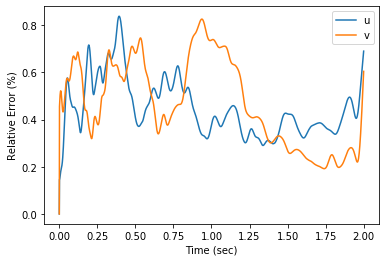


------------------------------------------------------------------------

amp=0.99


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2625.826001882553 sec

Best case is
# of residual basis: 52
# of residual sampes: 55

Time elapsed: 14.238962173461914 sec
average relative error of u: 0.46725062041781984%
average relative error of v: 0.5907407224894592%
maximum relative error of u: 0.7841239781058952%
maximum relative error of v: 0.8630044600252644%
maximum relative error: 0.8630044600252644%


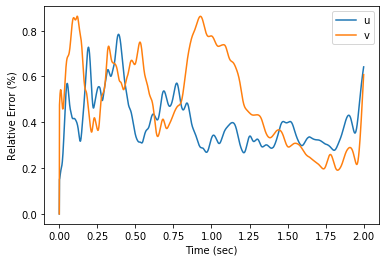


------------------------------------------------------------------------

amp=1.0


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2756.592000722885 sec

Best case is
# of residual basis: 55
# of residual sampes: 58

Time elapsed: 14.462971210479736 sec
average relative error of u: 0.45465678565167306%
average relative error of v: 0.6416141770447448%
maximum relative error of u: 0.7340606841482201%
maximum relative error of v: 0.9340324671535962%
maximum relative error: 0.9340324671535962%


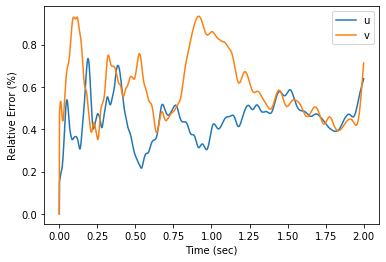


------------------------------------------------------------------------

amp=1.01


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2696.590995311737 sec

Best case is
# of residual basis: 46
# of residual sampes: 49

Time elapsed: 13.86500072479248 sec
average relative error of u: 0.455028524798143%
average relative error of v: 0.5995736267387913%
maximum relative error of u: 0.6982807432091037%
maximum relative error of v: 0.9608118070984354%
maximum relative error: 0.9608118070984354%


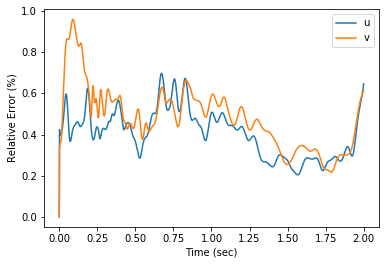


------------------------------------------------------------------------

amp=1.02


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2701.2159972190857 sec

Best case is
# of residual basis: 50
# of residual sampes: 53

Time elapsed: 14.353970766067505 sec
average relative error of u: 0.3669038266472664%
average relative error of v: 0.5254691426020894%
maximum relative error of u: 0.6319402534945991%
maximum relative error of v: 0.7471122509510572%
maximum relative error: 0.7471122509510572%


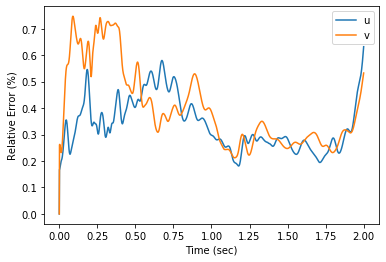


------------------------------------------------------------------------

amp=1.03


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2791.185995578766 sec

Best case is
# of residual basis: 50
# of residual sampes: 53

Time elapsed: 14.41196584701538 sec
average relative error of u: 0.3182604879483431%
average relative error of v: 0.41535873870910434%
maximum relative error of u: 0.5404872840048253%
maximum relative error of v: 0.6527976377581257%
maximum relative error: 0.6527976377581257%


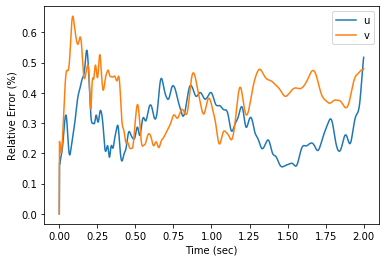


------------------------------------------------------------------------

amp=1.04


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2682.285975933075 sec

Best case is
# of residual basis: 52
# of residual sampes: 53

Time elapsed: 14.37396502494812 sec
average relative error of u: 0.3823568384912802%
average relative error of v: 0.37794245081843886%
maximum relative error of u: 0.7128206343341116%
maximum relative error of v: 0.6732629334364805%
maximum relative error: 0.7128206343341116%


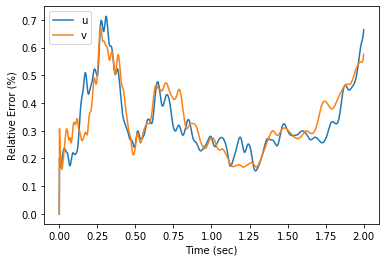


------------------------------------------------------------------------

amp=1.05


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2851.8349294662476 sec

Best case is
# of residual basis: 46
# of residual sampes: 58

Time elapsed: 14.659971475601196 sec
average relative error of u: 0.4056119315641025%
average relative error of v: 0.3949987417015825%
maximum relative error of u: 0.6994970778305574%
maximum relative error of v: 0.6739479084437594%
maximum relative error: 0.6994970778305574%


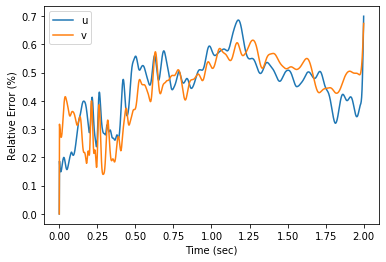


------------------------------------------------------------------------

amp=1.06


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2750.6121797561646 sec

Best case is
# of residual basis: 54
# of residual sampes: 57

Time elapsed: 14.813001871109009 sec
average relative error of u: 0.5946532703525382%
average relative error of v: 0.5592679357115817%
maximum relative error of u: 1.001758707037158%
maximum relative error of v: 1.0821942549371228%
maximum relative error: 1.0821942549371228%


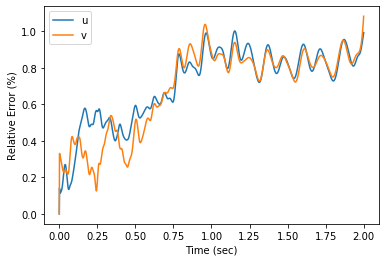


------------------------------------------------------------------------

amp=1.07


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2754.0 sec

Best case is
# of residual basis: 45
# of residual sampes: 57

Time elapsed: 14.4269700050354 sec
average relative error of u: 0.8568852762005561%
average relative error of v: 0.6587004309577048%
maximum relative error of u: 1.5920939332500588%
maximum relative error of v: 1.1912595176812926%
maximum relative error: 1.5920939332500588%


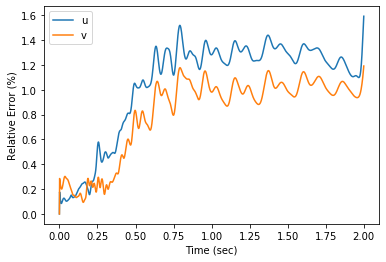


------------------------------------------------------------------------

amp=1.08


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2863.349912881851 sec

Best case is
# of residual basis: 45
# of residual sampes: 57

Time elapsed: 14.493998765945435 sec
average relative error of u: 0.46831868015851097%
average relative error of v: 0.4057300588588781%
maximum relative error of u: 1.128594257981744%
maximum relative error of v: 1.1223177547808514%
maximum relative error: 1.128594257981744%


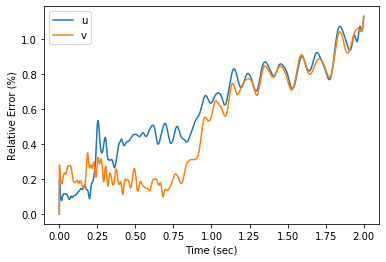


------------------------------------------------------------------------

amp=1.09


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2608.9220020771027 sec

Best case is
# of residual basis: 43
# of residual sampes: 55

Time elapsed: 14.908970832824707 sec
average relative error of u: 1.6257039331508325%
average relative error of v: 1.611417012864539%
maximum relative error of u: 4.269469846050555%
maximum relative error of v: 4.1860742603533225%
maximum relative error: 4.269469846050555%


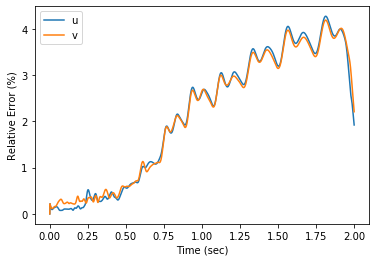


------------------------------------------------------------------------

amp=1.1


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2663.8221237659454 sec

Best case is
# of residual basis: 44
# of residual sampes: 48

Time elapsed: 15.452968120574951 sec
average relative error of u: 2.099445621371196%
average relative error of v: 2.6949206801973244%
maximum relative error of u: 4.189640952375644%
maximum relative error of v: 4.395369334997875%
maximum relative error: 4.395369334997875%


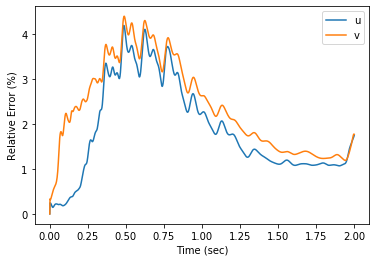


------------------------------------------------------------------------

amp=1.11


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2529.3415808677673 sec

Best case is
# of residual basis: 40
# of residual sampes: 43

Time elapsed: 14.30800199508667 sec
average relative error of u: 2.5278415264020975%
average relative error of v: 2.0693214261294925%
maximum relative error of u: 4.495537956111204%
maximum relative error of v: 4.572490400675284%
maximum relative error: 4.572490400675284%


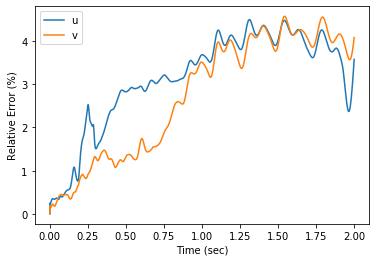


------------------------------------------------------------------------

amp=1.12


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2376.6023852825165 sec

Best case is
# of residual basis: 48
# of residual sampes: 59

Time elapsed: 14.67397141456604 sec
average relative error of u: 3.1544826449685273%
average relative error of v: 3.4365567642470776%
maximum relative error of u: 6.551145227383495%
maximum relative error of v: 6.441313553599477%
maximum relative error: 6.551145227383495%


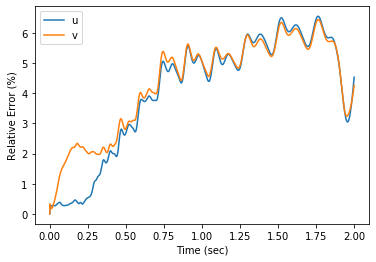


------------------------------------------------------------------------

amp=1.13


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 2103.5301644802094 sec

Best case is
# of residual basis: 42
# of residual sampes: 51

Time elapsed: 14.826971292495728 sec
average relative error of u: 1.7678766842092428%
average relative error of v: 1.404410561841292%
maximum relative error of u: 4.56830450051512%
maximum relative error of v: 4.533557483471404%
maximum relative error: 4.56830450051512%


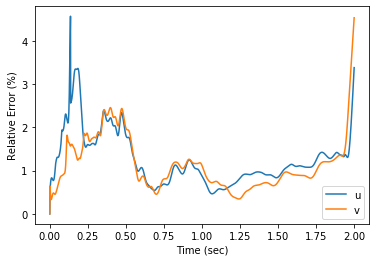


------------------------------------------------------------------------

amp=1.14


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 1873.104001045227 sec

Best case is
# of residual basis: 46
# of residual sampes: 49

Time elapsed: 14.165973901748657 sec
average relative error of u: 3.6627571255745472%
average relative error of v: 3.7367903474120805%
maximum relative error of u: 6.905298189326567%
maximum relative error of v: 6.916402155787268%
maximum relative error: 6.916402155787268%


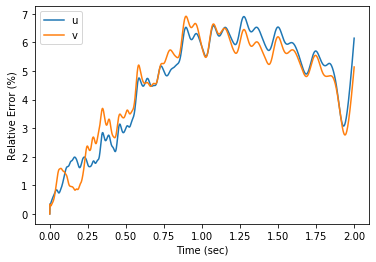


------------------------------------------------------------------------

amp=1.15


C:\Users\youngkyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



DEIM test time elapsed: 1768.137999534607 sec

Best case is
# of residual basis: 40
# of residual sampes: 50

Time elapsed: 14.769971132278442 sec
average relative error of u: 4.031840093099575%
average relative error of v: 3.8877637418660975%
maximum relative error of u: 6.8663019966099155%
maximum relative error of v: 6.671561745912189%
maximum relative error: 6.8663019966099155%


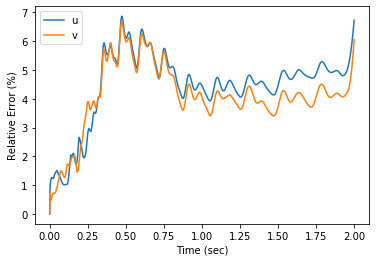


------------------------------------------------------------------------


In [11]:
ampArr=np.array([0.85,0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0,\
                 1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.1,1.11,1.12,1.13,1.14,1.15])
namp=ampArr.shape[0]
resultArr=np.zeros((namp,9))

for iii in range(namp):
    # load full order solution
    amp=ampArr[iii]
    print()
    print('amp={}'.format(amp))
    if Re==10000:
        file_name_FOM="./data/FOM_high_Re_amp_{}.p".format(amp)
    elif Re==100:
        file_name_FOM="./data/FOM_low_Re_amp_{}.p".format(amp)
    else:
        raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))
    
    FOM_solution=pickle.load(open(file_name_FOM,'rb'))   
    u_full=FOM_solution['u']
    v_full=FOM_solution['v']
    
    # IC
    u0=u_full[0]
    v0=v_full[0]
    
    # boundary for first order derivative term
    Bdudx0_cur=np.kron(u0[x0_raveled_indicies],x0_one_hot)
    Bdudy0_cur=np.kron(y0_one_hot,u0[y0_raveled_indicies])
    Bdvdx0_cur=np.kron(v0[x0_raveled_indicies],x0_one_hot)
    Bdvdy0_cur=np.kron(y0_one_hot,v0[y0_raveled_indicies])
    Bdudx1_cur=np.kron(u0[x1_raveled_indicies],x1_one_hot)
    Bdudy1_cur=np.kron(y1_one_hot,u0[y1_raveled_indicies])
    Bdvdx1_cur=np.kron(v0[x1_raveled_indicies],x1_one_hot)
    Bdvdy1_cur=np.kron(y1_one_hot,v0[y1_raveled_indicies])

    # boundary for second order derivative term
    bxu_cur=np.zeros(nxy)
    byu_cur=np.zeros(nxy)
    bxv_cur=np.zeros(nxy)
    byv_cur=np.zeros(nxy)

    bxu_cur[inner_x_raveled_indicies]=u0[x01_raveled_indicies]
    byu_cur[inner_y_raveled_indicies]=u0[y01_raveled_indicies]
    bxv_cur[inner_x_raveled_indicies]=v0[x01_raveled_indicies]
    byv_cur[inner_y_raveled_indicies]=v0[y01_raveled_indicies]
    
    # precompute terms
    au1_cur=(-1/dx*u_ref*(Mu_ref-Bdudx0_cur)-1/dy*v_ref*(Nu_ref-Bdudy0_cur) \
    +1/(Re*dx**2)*(Dxu_ref+bxu_cur)+1/(Re*dy**2)*(Dyu_ref+byu_cur)).astype('float32')
    Au2_cur=(-1/dx*(sp.diags(u_ref,format='csr').dot(M)+sp.diags(Mu_ref-Bdudx0_cur,format='csr')) \
    -1/dy*sp.diags(v_ref,format='csr').dot(N) \
    +1/(Re*dx**2)*Dx+1/(Re*dy**2)*Dy).astype('float32')
    au3_cur=(-1/dy*(Nu_ref-Bdudy0_cur)).astype('float32')

    av1_cur=(-1/dx*u_ref*(Mv_ref-Bdvdx0_cur)-1/dy*v_ref*(Nv_ref-Bdvdy0_cur) \
    +1/(Re*dx**2)*(Dxv_ref+bxv_cur)+1/(Re*dy**2)*(Dyv_ref+byv_cur)).astype('float32')
    av2_cur=(-1/dx*(Mv_ref-Bdvdx0_cur)).astype('float32')
    Av3_cur=(-1/dx*sp.diags(u_ref,format='csr').dot(M) \
    -1/dy*(sp.diags(v_ref,format='csr').dot(N)+sp.diags(Nv_ref-Bdvdy0_cur,format='csr')) \
    +1/(Re*dx**2)*Dx+1/(Re*dy**2)*Dy).astype('float32')

    Au2T_cur=Au2_cur.T
    Av3T_cur=Av3_cur.T
    
    # set parameters
    I_hat=np.eye(latent_dim,dtype='float32')

    maxitr=4
    tol=1e-6

    # IC for reduced state
    u_hat0=encoder_u_np_forward(u0[free_raveled_indicies].astype('float32')-u_ref)
    v_hat0=encoder_v_np_forward(v0[free_raveled_indicies].astype('float32')-v_ref)
    
    DEIM_test_tstart=time.time()

    # choose # of DEIM basis and DEIM samples
    DEIM_min=40
    DEIM_max=60

    n_test=int((DEIM_max-DEIM_min)*(DEIM_max-DEIM_min+1)/2)
    # print('Total # of test: {}'.format(n_test))

    # save test results: [DEIM_basis, DEIM_samples, Time_elapsed, Max_rel_err]
    test_results=np.zeros((n_test,4))

    test_count=0
    for DEIM_basis in np.arange(DEIM_min,DEIM_max):
        for DEIM_samples in np.arange(DEIM_basis,DEIM_max):
            test_count+=1
    #         print()
    #         print('Test #{}'.format(test_count))
    #         print('-'*72)
    #         print('DEIM_basis: {}, DEIM_samples: {}'.format(DEIM_basis,DEIM_samples))

            try:
                phi_u=U_u[:,:DEIM_basis]
                phi_v=U_v[:,:DEIM_basis]

                # Find DEIM smaple points and precompute
                z_u=DEIM(phi_u,DEIM_samples)
                z_v=DEIM(phi_v,DEIM_samples)

                Pu=phi_u.dot(np.linalg.pinv(phi_u[z_u]))
                Pv=phi_v.dot(np.linalg.pinv(phi_v[z_v]))

                PuTPu=Pu.T.dot(Pu)
                PvTPv=Pv.T.dot(Pv)

                # neigbor sample points
                z_uA=np.unique(np.nonzero(Au2_cur[z_u])[1])
                z_uM=np.unique(np.nonzero(M[z_u])[1])
                z_uN=np.unique(np.nonzero(N[z_u])[1])

                z_vA=np.unique(np.nonzero(Av3_cur[z_v])[1])
                z_vM=np.unique(np.nonzero(M[z_v])[1])
                z_vN=np.unique(np.nonzero(N[z_v])[1])

                z_union=np.union1d(z_uA,z_vA)

                z_uA_ind=z_union.searchsorted(z_uA)
                z_uM_ind=z_union.searchsorted(z_uM)
                z_uN_ind=z_union.searchsorted(z_uN)
                z_u_ind=z_union.searchsorted(z_u)

                z_vA_ind=z_union.searchsorted(z_vA)
                z_vM_ind=z_union.searchsorted(z_vM)
                z_vN_ind=z_union.searchsorted(z_vN)
                z_v_ind=z_union.searchsorted(z_v)

                # subnet for u
                m,M2=de_wu2.shape

                class Decoder_U_FC(nn.Module):

                    def __init__(self,):
                        super(Decoder_U_FC, self).__init__()
                        self.fc1 = nn.Linear(latent_dim,M2)
                        self.fc1.weight = nn.Parameter(torch.ones(de_wu1.shape))
                        self.fc1.bias = nn.Parameter(torch.ones(de_bu1.shape))
    #                     self.fc1.weight = nn.Parameter(torch.tensor(de_wu1))
    #                     self.fc1.bias = nn.Parameter(torch.tensor(de_bu1))

                        self.fc2 = nn.Linear(M2,m,bias=False)
                        self.fc2.weight = nn.Parameter(torch.ones(de_wu2.shape))
    #                     self.fc2.weight = nn.Parameter(torch.tensor(de_wu2))

                    def forward(self, x):
                        x = self.fc1(x)
                        x = self.fc2(x)
                        return x

                model = Decoder_U_FC()

                x_in=torch.ones(latent_dim)
                y_out=model(x_in)

                p_hr=z_union

                upstream=torch.zeros_like(y_out)
                upstream[p_hr]=1.0

                y_out.backward(upstream)

                # masks for subnet
                wu1_mask=model.fc1.weight.grad
                wu2_mask=model.fc2.weight.grad

                bu1_mask=model.fc1.bias.grad

                # subnet sparse weight
                idx1=wu1_mask.to_sparse()._indices()
                i1=idx1.numpy()[0]
                j1=idx1.numpy()[1]
                v1=de_wu1[i1,j1]
                wu1_sb_sp=sp.csr_matrix(sp.csr_matrix((v1,(i1,j1)),shape=wu1_mask.shape).toarray())

                idx2=wu2_mask.to_sparse()._indices()
                i2=idx2.numpy()[0]
                j2=idx2.numpy()[1]
                v2=de_wu2[i2,j2]
                wu2_sb_sp=sp.csr_matrix(sp.csr_matrix((v2,(i2,j2)),shape=wu2_mask.shape).toarray())

                # subnet compressed weight
                i1,j1,v1=sp.find(wu1_sb_sp)
                i1_unique,i1_inverse=np.unique(i1,return_inverse=True)
                i1_comp=np.arange(i1_unique.size)
                i1_comp=i1_comp[i1_inverse]
                j1_unique,j1_inverse=np.unique(j1,return_inverse=True)
                j1_comp=np.arange(j1_unique.size)
                j1_comp=j1_comp[j1_inverse]
                wu1_sb_comp_sp=sp.csr_matrix((v1,(i1_comp,j1_comp)),shape=(i1_unique.size,j1_unique.size))

                i2,j2,v2=sp.find(wu2_sb_sp)
                i2_unique,i2_inverse=np.unique(i2,return_inverse=True)
                i2_comp=np.arange(i2_unique.size)
                i2_comp=i2_comp[i2_inverse]
                j2_unique,j2_inverse=np.unique(j2,return_inverse=True)
                j2_comp=np.arange(j2_unique.size)
                j2_comp=j2_comp[j2_inverse]
                wu2_sb_comp_sp=sp.csr_matrix((v2,(i2_comp,j2_comp)),shape=(i2_unique.size,j2_unique.size))

                wu1_sb_comp_dense=wu1_sb_comp_sp.toarray()
                wu1_sb_comp_dense=wu1_sb_comp_dense[j2_unique]
                wu2_sb_comp_dense=wu2_sb_comp_sp.toarray()

                wu1_sb_comp_denseT=wu1_sb_comp_dense.T
                wu2_sb_comp_denseT=wu2_sb_comp_dense.T

                # subnet compressed bias
                bu1_sb_comp_dense=de_bu1[i1_unique]
                bu1_sb_comp_dense=bu1_sb_comp_dense[j2_unique]

                # Using sparse matrix
                wu2_sb_comp_sp=sp.csr_matrix(wu2_sb_comp_dense,dtype='float32')
                wu2_sb_comp_spT=sp.csr_matrix(wu2_sb_comp_denseT,dtype='float32')

                def decoder_u_sb_np_forward(x):
                    z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
                    a1 = sigmoid_np(z1)
                    y = wu2_sb_comp_dense.dot(a1)  
                    return y

                def decoder_u_sb_np_forward_backwardT(x):
                    z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
                    a1 = sigmoid_np(z1)
                    y = wu2_sb_comp_dense.dot(a1) 

                    dout = wu1_sb_comp_denseT
                    dout = (a1*(1-a1))*dout
                    dydxT = dout.dot(wu2_sb_comp_denseT)
                    return y,dydxT

                def decoder_u_sb_sp_forward(x):
                    z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
                    a1 = sigmoid_np(z1)
                    y = sp.csr_matrix.dot(wu2_sb_comp_sp,a1)
                    return y

                def decoder_u_sb_sp_forward_backwardT(x):
                    z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
                    a1 = sigmoid_np(z1)
                    y = sp.csr_matrix.dot(wu2_sb_comp_sp,a1)

                    dout = wu1_sb_comp_denseT
                    dout = (a1*(1-a1))*dout
                    dydxT = sp.csr_matrix.dot(dout,wu2_sb_comp_spT)
                    return y,dydxT

                # subnet for v
                m,M2=de_wv2.shape

                class Decoder_V_FC(nn.Module):

                    def __init__(self,):
                        super(Decoder_V_FC, self).__init__()
                        self.fc1 = nn.Linear(latent_dim,M2)
                        self.fc1.weight = nn.Parameter(torch.tensor(de_wv1))
                        self.fc1.bias = nn.Parameter(torch.tensor(de_bv1))

                        self.fc2 = nn.Linear(M2,m,bias=False)
                        self.fc2.weight = nn.Parameter(torch.tensor(de_wv2))

                    def forward(self, x):
                        x = self.fc1(x)
                        x = self.fc2(x)
                        return x

                model = Decoder_V_FC()

                x_in=torch.ones(latent_dim)
                y_out=model(x_in)

                p_hr=z_union

                upstream=torch.zeros_like(y_out)
                upstream[p_hr]=1.0

                y_out.backward(upstream)

                # masks for subnet
                wv1_mask=model.fc1.weight.grad
                wv2_mask=model.fc2.weight.grad

                bv1_mask=model.fc1.bias.grad

                # subnet sparse weight
                idx1=wv1_mask.to_sparse()._indices()
                i1=idx1.numpy()[0]
                j1=idx1.numpy()[1]
                v1=de_wv1[i1,j1]
                wv1_sb_sp=sp.csr_matrix(sp.csr_matrix((v1,(i1,j1)),shape=wv1_mask.shape).toarray())

                idx2=wv2_mask.to_sparse()._indices()
                i2=idx2.numpy()[0]
                j2=idx2.numpy()[1]
                v2=de_wv2[i2,j2]
                wv2_sb_sp=sp.csr_matrix(sp.csr_matrix((v2,(i2,j2)),shape=wv2_mask.shape).toarray())

                # subnet compressed weight
                i1,j1,v1=sp.find(wv1_sb_sp)
                i1_unique,i1_inverse=np.unique(i1,return_inverse=True)
                i1_comp=np.arange(i1_unique.size)
                i1_comp=i1_comp[i1_inverse]
                j1_unique,j1_inverse=np.unique(j1,return_inverse=True)
                j1_comp=np.arange(j1_unique.size)
                j1_comp=j1_comp[j1_inverse]
                wv1_sb_comp_sp=sp.csr_matrix((v1,(i1_comp,j1_comp)),shape=(i1_unique.size,j1_unique.size))

                i2,j2,v2=sp.find(wv2_sb_sp)
                i2_unique,i2_inverse=np.unique(i2,return_inverse=True)
                i2_comp=np.arange(i2_unique.size)
                i2_comp=i2_comp[i2_inverse]
                j2_unique,j2_inverse=np.unique(j2,return_inverse=True)
                j2_comp=np.arange(j2_unique.size)
                j2_comp=j2_comp[j2_inverse]
                wv2_sb_comp_sp=sp.csr_matrix((v2,(i2_comp,j2_comp)),shape=(i2_unique.size,j2_unique.size))

                wv1_sb_comp_dense=wv1_sb_comp_sp.toarray()
                wv2_sb_comp_dense=wv2_sb_comp_sp.toarray()

                wv1_sb_comp_denseT=wv1_sb_comp_dense.T
                wv2_sb_comp_denseT=wv2_sb_comp_dense.T

                # subnet compressed bias
                bv1_sb_comp_dense=de_bv1[i1_unique]

                # Using sparse matrix
                wv2_sb_comp_sp=sp.csr_matrix(wv2_sb_comp_dense,dtype='float32')
                wv2_sb_comp_spT=sp.csr_matrix(wv2_sb_comp_denseT,dtype='float32')

                def decoder_v_sb_np_forward(x):
                    z1 = wv1_sb_comp_dense.dot(x) + bv1_sb_comp_dense
                    a1 = sigmoid_np(z1)
                    y = wv2_sb_comp_dense.dot(a1)  
                    return y

                def decoder_v_sb_np_forward_backwardT(x):
                    z1 = wv1_sb_comp_dense.dot(x) + bv1_sb_comp_dense
                    a1 = sigmoid_np(z1)
                    y = wv2_sb_comp_dense.dot(a1) 

                    dout = wv1_sb_comp_denseT
                    dout = (a1*(1-a1))*dout
                    dydxT = dout.dot(wv2_sb_comp_denseT)
                    return y,dydxT

                def decoder_v_sb_sp_forward(x):
                    z1 = wv1_sb_comp_dense.dot(x) + bv1_sb_comp_dense
                    a1 = sigmoid_np(z1)
                    y = sp.csr_matrix.dot(wv2_sb_comp_sp,a1)
                    return y

                def decoder_v_sb_sp_forward_backwardT(x):
                    z1 = wv1_sb_comp_dense.dot(x) + bv1_sb_comp_dense
                    a1 = sigmoid_np(z1)
                    y = sp.csr_matrix.dot(wv2_sb_comp_sp,a1)

                    dout = wv1_sb_comp_denseT
                    dout = (a1*(1-a1))*dout
                    dydxT = sp.csr_matrix.dot(dout,wv2_sb_comp_spT)
                    return y,dydxT

                # precompute
                ZuTau1_cur=au1_cur[z_u]
                ZuTAu2_cur=Au2_cur[z_u][:,z_uA]
                ZuTau3_cur=au3_cur[z_u]

                ZvTav1_cur=av1_cur[z_v]
                ZvTav2_cur=av2_cur[z_v]
                ZvTAv3_cur=Av3_cur[z_v][:,z_vA]

                Au2T_curZu=Au2T_cur[z_uA][:,z_u]
                Av3T_curZv=Av3T_cur[z_vA][:,z_v]

                ZuTM=M[z_u][:,z_uM]
                ZuTN=N[z_u][:,z_uN]
                ZvTM=M[z_v][:,z_vM]
                ZvTN=N[z_v][:,z_vN]

                MTZu=MT[z_uM][:,z_u]
                NTZu=NT[z_uN][:,z_u]
                MTZv=MT[z_vM][:,z_v]
                NTZv=NT[z_vN][:,z_v]

                # define functions
                def ZuTtheta_u(g_u_sb,g_v_sb,ZuTMg_u,ZuTNg_u):
                    return -1/dx*g_u_sb[z_u_ind]*ZuTMg_u-1/dy*g_v_sb[z_u_ind]*ZuTNg_u

                def ZvTtheta_v(g_u_sb,g_v_sb,ZvTMg_v,ZvTNg_v):
                    return -1/dx*g_u_sb[z_v_ind]*ZvTMg_v-1/dy*g_v_sb[z_v_ind]*ZvTNg_v

                def dtheta_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu):
                    return -1/dx*(ZuTMg_u*Jg_u_sbT[:,z_u_ind]+g_u_sb[z_u_ind]*Jg_uTMTZu)-1/dy*g_v_sb[z_u_ind]*Jg_uTNTZu

                def dtheta_udv_hatTZu(ZuTNg_u,Jg_v_sbT):
                    return -1/dy*ZuTNg_u*Jg_v_sbT[:,z_u_ind]

                def dtheta_vdu_hatTZv(ZvTMg_v,Jg_u_sbT):
                    return -1/dx*ZvTMg_v*Jg_u_sbT[:,z_v_ind]

                def dtheta_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv):
                    return -1/dx*g_u_sb[z_v_ind]*Jg_vTMTZv-1/dy*(ZvTNg_v*Jg_v_sbT[:,z_v_ind]+g_v_sb[z_v_ind]*Jg_vTNTZv)

                def ZuTr_u(g_u_sb,g_v_sb,g_u_sb_prev,ZuTMg_u,ZuTNg_u):
                    return g_u_sb[z_u_ind]-g_u_sb_prev[z_u_ind]-dt*(ZuTau1_cur+ZuTAu2_cur.dot(g_u_sb[z_uA_ind])+ZuTau3_cur*g_v_sb[z_u_ind]\
                                                                    +ZuTtheta_u(g_u_sb,g_v_sb,ZuTMg_u,ZuTNg_u))

                def ZvTr_v(g_u_sb,g_v_sb,g_v_sb_prev,ZvTMg_v,ZvTNg_v):
                    return g_v_sb[z_v_ind]-g_v_sb_prev[z_v_ind]-dt*(ZvTav1_cur+ZvTav2_cur*g_u_sb[z_v_ind]+ZvTAv3_cur.dot(g_v_sb[z_vA_ind])\
                                                                    +ZvTtheta_v(g_u_sb,g_v_sb,ZvTMg_v,ZvTNg_v))

                def dr_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu):
                    return Jg_u_sbT[:,z_u_ind]-dt*(sp.csr_matrix.dot(Jg_u_sbT[:,z_uA_ind],Au2T_curZu)\
                                                   +dtheta_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu))

                def dr_udv_hatTZu(ZuTNg_u,Jg_v_sbT):
                    return -dt*(ZuTau3_cur*Jg_v_sbT[:,z_u_ind]+dtheta_udv_hatTZu(ZuTNg_u,Jg_v_sbT))

                def dr_vdu_hatTZv(ZvTMg_v,Jg_u_sbT):
                    return -dt*(ZvTav2_cur*Jg_u_sbT[:,z_v_ind]+dtheta_vdu_hatTZv(ZvTMg_v,Jg_u_sbT))

                def dr_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv):
                    return Jg_v_sbT[:,z_v_ind]-dt*(sp.csr_matrix.dot(Jg_v_sbT[:,z_vA_ind],Av3T_curZv)\
                                                   +dtheta_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv))

                def r_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur):
                    r_u_hat=dr_udu_hatTZu_cur.dot(PuTPu.dot(ZuTr_u_cur))+dr_vdu_hatTZv_cur.dot(PvTPv.dot(ZvTr_v_cur))
                    r_v_hat=dr_udv_hatTZu_cur.dot(PuTPu.dot(ZuTr_u_cur))+dr_vdv_hatTZv_cur.dot(PvTPv.dot(ZvTr_v_cur))
                    return np.concatenate((r_u_hat,r_v_hat))

                def J_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur):
                    J11_hat=dr_udu_hatTZu_cur.dot(PuTPu.dot(dr_udu_hatTZu_cur.T))+dr_vdu_hatTZv_cur.dot(PvTPv.dot(dr_vdu_hatTZv_cur.T))
                    J12_hat=dr_udu_hatTZu_cur.dot(PuTPu.dot(dr_udv_hatTZu_cur.T))+dr_vdu_hatTZv_cur.dot(PvTPv.dot(dr_vdv_hatTZv_cur.T))
                    J21_hat=dr_udv_hatTZu_cur.dot(PuTPu.dot(dr_udu_hatTZu_cur.T))+dr_vdv_hatTZv_cur.dot(PvTPv.dot(dr_vdu_hatTZv_cur.T))
                    J22_hat=dr_udv_hatTZu_cur.dot(PuTPu.dot(dr_udv_hatTZu_cur.T))+dr_vdv_hatTZv_cur.dot(PvTPv.dot(dr_vdv_hatTZv_cur.T))
                    return np.block([[J11_hat,J12_hat],[J21_hat,J22_hat]])

                # run NM-ROM
                t_start_pg_DEIM=time.time()

                # solution
                u_reduced=np.zeros((nt+1,latent_dim))
                v_reduced=np.zeros((nt+1,latent_dim))
                u_rom_pg_DEIM=np.zeros((nt+1,ny*nx))
                v_rom_pg_DEIM=np.zeros((nt+1,ny*nx))

                # IC
                u_reduced[0]=np.copy(u_hat0)
                v_reduced[0]=np.copy(v_hat0)
                u_rom_pg_DEIM[0]=np.copy(u0)
                v_rom_pg_DEIM[0]=np.copy(v0)

                for k in range(nt):
        #             print("")
        #             print(k,"th time step:")

                    u_hat_prev=np.copy(u_reduced[k])
                    v_hat_prev=np.copy(v_reduced[k])

                    g_u_sb_prev=u_rom_pg_DEIM[k,free_raveled_indicies[z_union]]-u_ref[z_union]
                    g_v_sb_prev=v_rom_pg_DEIM[k,free_raveled_indicies[z_union]]-v_ref[z_union]

                    u_hat=np.copy(u_reduced[k])
                    v_hat=np.copy(v_reduced[k])

                    g_u_sb,Jg_u_sbT=decoder_u_sb_np_forward_backwardT(u_hat)
                    g_v_sb,Jg_v_sbT=decoder_v_sb_np_forward_backwardT(v_hat)

                    ZuTMg_u=ZuTM.dot(g_u_sb[z_uM_ind])
                    ZuTNg_u=ZuTN.dot(g_u_sb[z_uN_ind])
                    ZvTMg_v=ZvTM.dot(g_v_sb[z_vM_ind])
                    ZvTNg_v=ZvTN.dot(g_v_sb[z_vN_ind])

                    Jg_uTMTZu=sp.csc_matrix.dot(Jg_u_sbT[:,z_uM_ind],MTZu)
                    Jg_uTNTZu=sp.csc_matrix.dot(Jg_u_sbT[:,z_uN_ind],NTZu)
                    Jg_vTMTZv=sp.csc_matrix.dot(Jg_v_sbT[:,z_vM_ind],MTZv)
                    Jg_vTNTZv=sp.csc_matrix.dot(Jg_v_sbT[:,z_vN_ind],NTZv)

                    ZuTr_u_cur=ZuTr_u(g_u_sb,g_v_sb,g_u_sb_prev,ZuTMg_u,ZuTNg_u)
                    ZvTr_v_cur=ZvTr_v(g_u_sb,g_v_sb,g_v_sb_prev,ZvTMg_v,ZvTNg_v)

                    dr_udu_hatTZu_cur=dr_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu)
                    dr_udv_hatTZu_cur=dr_udv_hatTZu(ZuTNg_u,Jg_v_sbT)
                    dr_vdu_hatTZv_cur=dr_vdu_hatTZv(ZvTMg_v,Jg_u_sbT)
                    dr_vdv_hatTZv_cur=dr_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv)

                    residual_hat=r_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur)

                    for itr in range(maxitr):
                        Jacobian_hat=J_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur)

                        delta_reduced=np.linalg.solve(Jacobian_hat,-residual_hat)

                        u_hat+=delta_reduced[:latent_dim]
                        v_hat+=delta_reduced[latent_dim:]

                        g_u_sb,Jg_u_sbT=decoder_u_sb_np_forward_backwardT(u_hat)
                        g_v_sb,Jg_v_sbT=decoder_v_sb_np_forward_backwardT(v_hat)

                        ZuTMg_u=ZuTM.dot(g_u_sb[z_uM_ind])
                        ZuTNg_u=ZuTN.dot(g_u_sb[z_uN_ind])
                        ZvTMg_v=ZvTM.dot(g_v_sb[z_vM_ind])
                        ZvTNg_v=ZvTN.dot(g_v_sb[z_vN_ind])

                        Jg_uTMTZu=sp.csc_matrix.dot(Jg_u_sbT[:,z_uM_ind],MTZu)
                        Jg_uTNTZu=sp.csc_matrix.dot(Jg_u_sbT[:,z_uN_ind],NTZu)
                        Jg_vTMTZv=sp.csc_matrix.dot(Jg_v_sbT[:,z_vM_ind],MTZv)
                        Jg_vTNTZv=sp.csc_matrix.dot(Jg_v_sbT[:,z_vN_ind],NTZv)

                        ZuTr_u_cur=ZuTr_u(g_u_sb,g_v_sb,g_u_sb_prev,ZuTMg_u,ZuTNg_u)
                        ZvTr_v_cur=ZvTr_v(g_u_sb,g_v_sb,g_v_sb_prev,ZvTMg_v,ZvTNg_v)

                        dr_udu_hatTZu_cur=dr_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu)
                        dr_udv_hatTZu_cur=dr_udv_hatTZu(ZuTNg_u,Jg_v_sbT)
                        dr_vdu_hatTZv_cur=dr_vdu_hatTZv(ZvTMg_v,Jg_u_sbT)
                        dr_vdv_hatTZv_cur=dr_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv)

                        residual_hat=r_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur)

                        R=np.linalg.norm(residual_hat)
    #                     print(itr,"th Newton iteration", "R:", "{:.8e}".format(R))

                        if R<tol:
                            u_reduced[k+1]=u_hat.copy()
                            v_reduced[k+1]=v_hat.copy()
                            u_rom_pg_DEIM[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
                            v_rom_pg_DEIM[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
                            # BC from exact solution
                            u_rom_pg_DEIM[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
                            v_rom_pg_DEIM[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()
                            break

                    if R>=tol:
    #                     print("\n non converged after {}th iteration".format(maxitr))
#                         break  
                        u_reduced[k+1]=u_hat.copy()
                        v_reduced[k+1]=v_hat.copy()
                        u_rom_pg_DEIM[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
                        v_rom_pg_DEIM[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
                        # BC from exact solution
                        u_rom_pg_DEIM[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
                        v_rom_pg_DEIM[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()

#                     u_reduced[k+1]=u_hat.copy()
#                     v_reduced[k+1]=v_hat.copy()
#                     u_rom_pg_DEIM[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
#                     v_rom_pg_DEIM[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
#                     # BC from exact solution
#                     u_rom_pg_DEIM[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
#                     v_rom_pg_DEIM[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()

                t_elapsed_pg_DEIM=time.time()-t_start_pg_DEIM
    #             print()
    #             print('Time elapsed: {} sec'.format(t_elapsed_pg_DEIM))

                # compute errors
                u_rel_err=np.linalg.norm(u_full-u_rom_pg_DEIM,ord=2,axis=1)/np.linalg.norm(u_full,ord=2,axis=1)*100
                v_rel_err=np.linalg.norm(v_full-v_rom_pg_DEIM,ord=2,axis=1)/np.linalg.norm(v_full,ord=2,axis=1)*100
    #             plt.plot(dt*np.arange(nt+1),u_rel_err,dt*np.arange(nt+1),v_rel_err)
    #             plt.xlabel('Time (sec)')
    #             plt.ylabel('Relative Error (%)')
    #             plt.legend(('u','v'))
    #             plt.show()

                u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_rom_pg_DEIM,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
                v_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(v_full-v_rom_pg_DEIM,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(v_full,ord=2,axis=1)**2))*100

    #             print("average relative error of u: {}%".format(u_avg_rel_err))
    #             print("average relative error of v: {}%".format(v_avg_rel_err))
    #             print()
    #             print("maximum relative error of u: {}%".format(np.max(u_rel_err)))
    #             print("maximum relative error of v: {}%".format(np.max(v_rel_err)))
                max_rel_err = np.max([u_rel_err,v_rel_err])
    #             print()
    #             print("maximum relative error: {}%".format(max_rel_err))
    #             print('-'*72)      

                test_results[test_count-1]=[DEIM_basis,DEIM_samples,t_elapsed_pg_DEIM,max_rel_err]            
            except np.linalg.LinAlgError as err:
                if 'Singular matrix' in str(err):
    #                 print()
    #                 print('Error due to singular matrix')
    #                 print('-'*72)

                    test_results[test_count-1]=[DEIM_basis,DEIM_samples,0.0,np.inf]
                else:
                    print("Unexpected error:", sys.exc_info()[0])
                    raise
            except:
                print("Unexpected error:", sys.exc_info()[0])
                raise

    DEIM_test_telapsed=time.time()-DEIM_test_tstart
    print()
    print('DEIM test time elapsed: {} sec'.format(DEIM_test_telapsed))

    # Run the best case
    # choose # of DEIM basis and DEIM samples
    DEIM_basis=int(test_results[np.argsort(test_results[:,-1])[0]][0])
    DEIM_samples=int(test_results[np.argsort(test_results[:,-1])[0]][1])
    print()
    print('Best case is')
    print('# of residual basis: {}'.format(DEIM_basis))
    print('# of residual sampes: {}'.format(DEIM_samples))

    phi_u=U_u[:,:DEIM_basis]
    phi_v=U_v[:,:DEIM_basis]

    # Find DEIM smaple points and precompute
    z_u=DEIM(phi_u,DEIM_samples)
    z_v=DEIM(phi_v,DEIM_samples)

    Pu=phi_u.dot(np.linalg.pinv(phi_u[z_u]))
    Pv=phi_v.dot(np.linalg.pinv(phi_v[z_v]))

    PuTPu=Pu.T.dot(Pu)
    PvTPv=Pv.T.dot(Pv)

    # neigbor sample points
    z_uA=np.unique(np.nonzero(Au2_cur[z_u])[1])
    z_uM=np.unique(np.nonzero(M[z_u])[1])
    z_uN=np.unique(np.nonzero(N[z_u])[1])

    z_vA=np.unique(np.nonzero(Av3_cur[z_v])[1])
    z_vM=np.unique(np.nonzero(M[z_v])[1])
    z_vN=np.unique(np.nonzero(N[z_v])[1])

    z_union=np.union1d(z_uA,z_vA)

    z_uA_ind=z_union.searchsorted(z_uA)
    z_uM_ind=z_union.searchsorted(z_uM)
    z_uN_ind=z_union.searchsorted(z_uN)
    z_u_ind=z_union.searchsorted(z_u)

    z_vA_ind=z_union.searchsorted(z_vA)
    z_vM_ind=z_union.searchsorted(z_vM)
    z_vN_ind=z_union.searchsorted(z_vN)
    z_v_ind=z_union.searchsorted(z_v)

    # subnet for u
    m,M2=de_wu2.shape

    class Decoder_U_FC(nn.Module):

        def __init__(self,):
            super(Decoder_U_FC, self).__init__()
            self.fc1 = nn.Linear(latent_dim,M2)
            self.fc1.weight = nn.Parameter(torch.ones(de_wu1.shape))
            self.fc1.bias = nn.Parameter(torch.ones(de_bu1.shape))
    #         self.fc1.weight = nn.Parameter(torch.tensor(de_wu1))
    #         self.fc1.bias = nn.Parameter(torch.tensor(de_bu1))

            self.fc2 = nn.Linear(M2,m,bias=False)
            self.fc2.weight = nn.Parameter(torch.ones(de_wu2.shape))
    #         self.fc2.weight = nn.Parameter(torch.tensor(de_wu2))

        def forward(self, x):
            x = self.fc1(x)
            x = self.fc2(x)
            return x

    model = Decoder_U_FC()

    x_in=torch.ones(latent_dim)
    y_out=model(x_in)

    p_hr=z_union

    upstream=torch.zeros_like(y_out)
    upstream[p_hr]=1.0

    y_out.backward(upstream)

    # masks for subnet
    wu1_mask=model.fc1.weight.grad
    wu2_mask=model.fc2.weight.grad

    bu1_mask=model.fc1.bias.grad

    # subnet sparse weight
    idx1=wu1_mask.to_sparse()._indices()
    i1=idx1.numpy()[0]
    j1=idx1.numpy()[1]
    v1=de_wu1[i1,j1]
    wu1_sb_sp=sp.csr_matrix(sp.csr_matrix((v1,(i1,j1)),shape=wu1_mask.shape).toarray())

    idx2=wu2_mask.to_sparse()._indices()
    i2=idx2.numpy()[0]
    j2=idx2.numpy()[1]
    v2=de_wu2[i2,j2]
    wu2_sb_sp=sp.csr_matrix(sp.csr_matrix((v2,(i2,j2)),shape=wu2_mask.shape).toarray())

    # subnet compressed weight
    i1,j1,v1=sp.find(wu1_sb_sp)
    i1_unique,i1_inverse=np.unique(i1,return_inverse=True)
    i1_comp=np.arange(i1_unique.size)
    i1_comp=i1_comp[i1_inverse]
    j1_unique,j1_inverse=np.unique(j1,return_inverse=True)
    j1_comp=np.arange(j1_unique.size)
    j1_comp=j1_comp[j1_inverse]
    wu1_sb_comp_sp=sp.csr_matrix((v1,(i1_comp,j1_comp)),shape=(i1_unique.size,j1_unique.size))

    i2,j2,v2=sp.find(wu2_sb_sp)
    i2_unique,i2_inverse=np.unique(i2,return_inverse=True)
    i2_comp=np.arange(i2_unique.size)
    i2_comp=i2_comp[i2_inverse]
    j2_unique,j2_inverse=np.unique(j2,return_inverse=True)
    j2_comp=np.arange(j2_unique.size)
    j2_comp=j2_comp[j2_inverse]
    wu2_sb_comp_sp=sp.csr_matrix((v2,(i2_comp,j2_comp)),shape=(i2_unique.size,j2_unique.size))

    wu1_sb_comp_dense=wu1_sb_comp_sp.toarray()
    wu1_sb_comp_dense=wu1_sb_comp_dense[j2_unique]
    wu2_sb_comp_dense=wu2_sb_comp_sp.toarray()

    wu1_sb_comp_denseT=wu1_sb_comp_dense.T
    wu2_sb_comp_denseT=wu2_sb_comp_dense.T

    # subnet compressed bias
    bu1_sb_comp_dense=de_bu1[i1_unique]
    bu1_sb_comp_dense=bu1_sb_comp_dense[j2_unique]

    # Using sparse matrix
    wu2_sb_comp_sp=sp.csr_matrix(wu2_sb_comp_dense,dtype='float32')
    wu2_sb_comp_spT=sp.csr_matrix(wu2_sb_comp_denseT,dtype='float32')

    def decoder_u_sb_np_forward(x):
        z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
        a1 = sigmoid_np(z1)
        y = wu2_sb_comp_dense.dot(a1)  
        return y

    def decoder_u_sb_np_forward_backwardT(x):
        z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
        a1 = sigmoid_np(z1)
        y = wu2_sb_comp_dense.dot(a1) 

        dout = wu1_sb_comp_denseT
        dout = (a1*(1-a1))*dout
        dydxT = dout.dot(wu2_sb_comp_denseT)
        return y,dydxT

    def decoder_u_sb_sp_forward(x):
        z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
        a1 = sigmoid_np(z1)
        y = sp.csr_matrix.dot(wu2_sb_comp_sp,a1)
        return y

    def decoder_u_sb_sp_forward_backwardT(x):
        z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
        a1 = sigmoid_np(z1)
        y = sp.csr_matrix.dot(wu2_sb_comp_sp,a1)

        dout = wu1_sb_comp_denseT
        dout = (a1*(1-a1))*dout
        dydxT = sp.csr_matrix.dot(dout,wu2_sb_comp_spT)
        return y,dydxT

    # subnet for v
    m,M2=de_wv2.shape

    class Decoder_V_FC(nn.Module):

        def __init__(self,):
            super(Decoder_V_FC, self).__init__()
            self.fc1 = nn.Linear(latent_dim,M2)
            self.fc1.weight = nn.Parameter(torch.ones(de_wv1.shape))
            self.fc1.bias = nn.Parameter(torch.ones(de_bv1.shape))
    #         self.fc1.weight = nn.Parameter(torch.tensor(de_wv1))
    #         self.fc1.bias = nn.Parameter(torch.tensor(de_bv1))

            self.fc2 = nn.Linear(M2,m,bias=False)
            self.fc2.weight = nn.Parameter(torch.ones(de_wv2.shape))
    #         self.fc2.weight = nn.Parameter(torch.tensor(de_wv2))

        def forward(self, x):
            x = self.fc1(x)
            x = self.fc2(x)
            return x

    model = Decoder_V_FC()

    x_in=torch.ones(latent_dim)
    y_out=model(x_in)

    p_hr=z_union

    upstream=torch.zeros_like(y_out)
    upstream[p_hr]=1.0

    y_out.backward(upstream)

    # masks for subnet
    wv1_mask=model.fc1.weight.grad
    wv2_mask=model.fc2.weight.grad

    bv1_mask=model.fc1.bias.grad

    # subnet sparse weight
    idx1=wv1_mask.to_sparse()._indices()
    i1=idx1.numpy()[0]
    j1=idx1.numpy()[1]
    v1=de_wv1[i1,j1]
    wv1_sb_sp=sp.csr_matrix(sp.csr_matrix((v1,(i1,j1)),shape=wv1_mask.shape).toarray())

    idx2=wv2_mask.to_sparse()._indices()
    i2=idx2.numpy()[0]
    j2=idx2.numpy()[1]
    v2=de_wv2[i2,j2]
    wv2_sb_sp=sp.csr_matrix(sp.csr_matrix((v2,(i2,j2)),shape=wv2_mask.shape).toarray())

    # subnet compressed weight
    i1,j1,v1=sp.find(wv1_sb_sp)
    i1_unique,i1_inverse=np.unique(i1,return_inverse=True)
    i1_comp=np.arange(i1_unique.size)
    i1_comp=i1_comp[i1_inverse]
    j1_unique,j1_inverse=np.unique(j1,return_inverse=True)
    j1_comp=np.arange(j1_unique.size)
    j1_comp=j1_comp[j1_inverse]
    wv1_sb_comp_sp=sp.csr_matrix((v1,(i1_comp,j1_comp)),shape=(i1_unique.size,j1_unique.size))

    i2,j2,v2=sp.find(wv2_sb_sp)
    i2_unique,i2_inverse=np.unique(i2,return_inverse=True)
    i2_comp=np.arange(i2_unique.size)
    i2_comp=i2_comp[i2_inverse]
    j2_unique,j2_inverse=np.unique(j2,return_inverse=True)
    j2_comp=np.arange(j2_unique.size)
    j2_comp=j2_comp[j2_inverse]
    wv2_sb_comp_sp=sp.csr_matrix((v2,(i2_comp,j2_comp)),shape=(i2_unique.size,j2_unique.size))

    wv1_sb_comp_dense=wv1_sb_comp_sp.toarray()
    wv1_sb_comp_dense=wv1_sb_comp_dense[j2_unique]
    wv2_sb_comp_dense=wv2_sb_comp_sp.toarray()

    wv1_sb_comp_denseT=wv1_sb_comp_dense.T
    wv2_sb_comp_denseT=wv2_sb_comp_dense.T

    # subnet compressed bias
    bv1_sb_comp_dense=de_bv1[i1_unique]
    bv1_sb_comp_dense=bv1_sb_comp_dense[j2_unique]

    # Using sparse matrix
    wv2_sb_comp_sp=sp.csr_matrix(wv2_sb_comp_dense,dtype='float32')
    wv2_sb_comp_spT=sp.csr_matrix(wv2_sb_comp_denseT,dtype='float32')

    def decoder_v_sb_np_forward(x):
        z1 = wv1_sb_comp_dense.dot(x) + bv1_sb_comp_dense
        a1 = sigmoid_np(z1)
        y = wv2_sb_comp_dense.dot(a1)  
        return y

    def decoder_v_sb_np_forward_backwardT(x):
        z1 = wv1_sb_comp_dense.dot(x) + bv1_sb_comp_dense
        a1 = sigmoid_np(z1)
        y = wv2_sb_comp_dense.dot(a1) 

        dout = wv1_sb_comp_denseT
        dout = (a1*(1-a1))*dout
        dydxT = dout.dot(wv2_sb_comp_denseT)
        return y,dydxT

    def decoder_v_sb_sp_forward(x):
        z1 = wv1_sb_comp_dense.dot(x) + bv1_sb_comp_dense
        a1 = sigmoid_np(z1)
        y = sp.csr_matrix.dot(wv2_sb_comp_sp,a1)
        return y

    def decoder_v_sb_sp_forward_backwardT(x):
        z1 = wv1_sb_comp_dense.dot(x) + bv1_sb_comp_dense
        a1 = sigmoid_np(z1)
        y = sp.csr_matrix.dot(wv2_sb_comp_sp,a1)

        dout = wv1_sb_comp_denseT
        dout = (a1*(1-a1))*dout
        dydxT = sp.csr_matrix.dot(dout,wv2_sb_comp_spT)
        return y,dydxT

    # precompute
    ZuTau1_cur=au1_cur[z_u]
    ZuTAu2_cur=Au2_cur[z_u][:,z_uA]
    ZuTau3_cur=au3_cur[z_u]

    ZvTav1_cur=av1_cur[z_v]
    ZvTav2_cur=av2_cur[z_v]
    ZvTAv3_cur=Av3_cur[z_v][:,z_vA]

    Au2T_curZu=Au2T_cur[z_uA][:,z_u]
    Av3T_curZv=Av3T_cur[z_vA][:,z_v]

    ZuTM=M[z_u][:,z_uM]
    ZuTN=N[z_u][:,z_uN]
    ZvTM=M[z_v][:,z_vM]
    ZvTN=N[z_v][:,z_vN]

    MTZu=MT[z_uM][:,z_u]
    NTZu=NT[z_uN][:,z_u]
    MTZv=MT[z_vM][:,z_v]
    NTZv=NT[z_vN][:,z_v]

    # define functions
    def ZuTtheta_u(g_u_sb,g_v_sb,ZuTMg_u,ZuTNg_u):
        return -1/dx*g_u_sb[z_u_ind]*ZuTMg_u-1/dy*g_v_sb[z_u_ind]*ZuTNg_u

    def ZvTtheta_v(g_u_sb,g_v_sb,ZvTMg_v,ZvTNg_v):
        return -1/dx*g_u_sb[z_v_ind]*ZvTMg_v-1/dy*g_v_sb[z_v_ind]*ZvTNg_v

    def dtheta_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu):
        return -1/dx*(ZuTMg_u*Jg_u_sbT[:,z_u_ind]+g_u_sb[z_u_ind]*Jg_uTMTZu)-1/dy*g_v_sb[z_u_ind]*Jg_uTNTZu

    def dtheta_udv_hatTZu(ZuTNg_u,Jg_v_sbT):
        return -1/dy*ZuTNg_u*Jg_v_sbT[:,z_u_ind]

    def dtheta_vdu_hatTZv(ZvTMg_v,Jg_u_sbT):
        return -1/dx*ZvTMg_v*Jg_u_sbT[:,z_v_ind]

    def dtheta_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv):
        return -1/dx*g_u_sb[z_v_ind]*Jg_vTMTZv-1/dy*(ZvTNg_v*Jg_v_sbT[:,z_v_ind]+g_v_sb[z_v_ind]*Jg_vTNTZv)

    def ZuTr_u(g_u_sb,g_v_sb,g_u_sb_prev,ZuTMg_u,ZuTNg_u):
        return g_u_sb[z_u_ind]-g_u_sb_prev[z_u_ind]-dt*(ZuTau1_cur+ZuTAu2_cur.dot(g_u_sb[z_uA_ind])+ZuTau3_cur*g_v_sb[z_u_ind]\
                                                        +ZuTtheta_u(g_u_sb,g_v_sb,ZuTMg_u,ZuTNg_u))

    def ZvTr_v(g_u_sb,g_v_sb,g_v_sb_prev,ZvTMg_v,ZvTNg_v):
        return g_v_sb[z_v_ind]-g_v_sb_prev[z_v_ind]-dt*(ZvTav1_cur+ZvTav2_cur*g_u_sb[z_v_ind]+ZvTAv3_cur.dot(g_v_sb[z_vA_ind])\
                                                        +ZvTtheta_v(g_u_sb,g_v_sb,ZvTMg_v,ZvTNg_v))

    def dr_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu):
        return Jg_u_sbT[:,z_u_ind]-dt*(sp.csr_matrix.dot(Jg_u_sbT[:,z_uA_ind],Au2T_curZu)\
                                       +dtheta_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu))

    def dr_udv_hatTZu(ZuTNg_u,Jg_v_sbT):
        return -dt*(ZuTau3_cur*Jg_v_sbT[:,z_u_ind]+dtheta_udv_hatTZu(ZuTNg_u,Jg_v_sbT))

    def dr_vdu_hatTZv(ZvTMg_v,Jg_u_sbT):
        return -dt*(ZvTav2_cur*Jg_u_sbT[:,z_v_ind]+dtheta_vdu_hatTZv(ZvTMg_v,Jg_u_sbT))

    def dr_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv):
        return Jg_v_sbT[:,z_v_ind]-dt*(sp.csr_matrix.dot(Jg_v_sbT[:,z_vA_ind],Av3T_curZv)\
                                       +dtheta_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv))

    def r_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur):
        r_u_hat=dr_udu_hatTZu_cur.dot(PuTPu.dot(ZuTr_u_cur))+dr_vdu_hatTZv_cur.dot(PvTPv.dot(ZvTr_v_cur))
        r_v_hat=dr_udv_hatTZu_cur.dot(PuTPu.dot(ZuTr_u_cur))+dr_vdv_hatTZv_cur.dot(PvTPv.dot(ZvTr_v_cur))
        return np.concatenate((r_u_hat,r_v_hat))

    def J_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur):
        J11_hat=dr_udu_hatTZu_cur.dot(PuTPu.dot(dr_udu_hatTZu_cur.T))+dr_vdu_hatTZv_cur.dot(PvTPv.dot(dr_vdu_hatTZv_cur.T))
        J12_hat=dr_udu_hatTZu_cur.dot(PuTPu.dot(dr_udv_hatTZu_cur.T))+dr_vdu_hatTZv_cur.dot(PvTPv.dot(dr_vdv_hatTZv_cur.T))
        J21_hat=dr_udv_hatTZu_cur.dot(PuTPu.dot(dr_udu_hatTZu_cur.T))+dr_vdv_hatTZv_cur.dot(PvTPv.dot(dr_vdu_hatTZv_cur.T))
        J22_hat=dr_udv_hatTZu_cur.dot(PuTPu.dot(dr_udv_hatTZu_cur.T))+dr_vdv_hatTZv_cur.dot(PvTPv.dot(dr_vdv_hatTZv_cur.T))
        return np.block([[J11_hat,J12_hat],[J21_hat,J22_hat]])

    # run NM-ROM
    t_start_pg_DEIM=time.time()

    # solution
    u_reduced=np.zeros((nt+1,latent_dim))
    v_reduced=np.zeros((nt+1,latent_dim))
    u_rom_pg_DEIM=np.zeros((nt+1,ny*nx))
    v_rom_pg_DEIM=np.zeros((nt+1,ny*nx))

    # IC
    u_reduced[0]=np.copy(u_hat0)
    v_reduced[0]=np.copy(v_hat0)
    u_rom_pg_DEIM[0]=np.copy(u0)
    v_rom_pg_DEIM[0]=np.copy(v0)

    for k in range(nt):
    #             print("")
    #             print(k,"th time step:")

        u_hat_prev=np.copy(u_reduced[k])
        v_hat_prev=np.copy(v_reduced[k])

        g_u_sb_prev=u_rom_pg_DEIM[k,free_raveled_indicies[z_union]]-u_ref[z_union]
        g_v_sb_prev=v_rom_pg_DEIM[k,free_raveled_indicies[z_union]]-v_ref[z_union]

        u_hat=np.copy(u_reduced[k])
        v_hat=np.copy(v_reduced[k])

        g_u_sb,Jg_u_sbT=decoder_u_sb_np_forward_backwardT(u_hat)
        g_v_sb,Jg_v_sbT=decoder_v_sb_np_forward_backwardT(v_hat)

        ZuTMg_u=ZuTM.dot(g_u_sb[z_uM_ind])
        ZuTNg_u=ZuTN.dot(g_u_sb[z_uN_ind])
        ZvTMg_v=ZvTM.dot(g_v_sb[z_vM_ind])
        ZvTNg_v=ZvTN.dot(g_v_sb[z_vN_ind])

        Jg_uTMTZu=sp.csc_matrix.dot(Jg_u_sbT[:,z_uM_ind],MTZu)
        Jg_uTNTZu=sp.csc_matrix.dot(Jg_u_sbT[:,z_uN_ind],NTZu)
        Jg_vTMTZv=sp.csc_matrix.dot(Jg_v_sbT[:,z_vM_ind],MTZv)
        Jg_vTNTZv=sp.csc_matrix.dot(Jg_v_sbT[:,z_vN_ind],NTZv)

        ZuTr_u_cur=ZuTr_u(g_u_sb,g_v_sb,g_u_sb_prev,ZuTMg_u,ZuTNg_u)
        ZvTr_v_cur=ZvTr_v(g_u_sb,g_v_sb,g_v_sb_prev,ZvTMg_v,ZvTNg_v)

        dr_udu_hatTZu_cur=dr_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu)
        dr_udv_hatTZu_cur=dr_udv_hatTZu(ZuTNg_u,Jg_v_sbT)
        dr_vdu_hatTZv_cur=dr_vdu_hatTZv(ZvTMg_v,Jg_u_sbT)
        dr_vdv_hatTZv_cur=dr_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv)

        residual_hat=r_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur)

        for itr in range(maxitr):
            Jacobian_hat=J_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur)

            delta_reduced=np.linalg.solve(Jacobian_hat,-residual_hat)

            u_hat+=delta_reduced[:latent_dim]
            v_hat+=delta_reduced[latent_dim:]

            g_u_sb,Jg_u_sbT=decoder_u_sb_np_forward_backwardT(u_hat)
            g_v_sb,Jg_v_sbT=decoder_v_sb_np_forward_backwardT(v_hat)

            ZuTMg_u=ZuTM.dot(g_u_sb[z_uM_ind])
            ZuTNg_u=ZuTN.dot(g_u_sb[z_uN_ind])
            ZvTMg_v=ZvTM.dot(g_v_sb[z_vM_ind])
            ZvTNg_v=ZvTN.dot(g_v_sb[z_vN_ind])

            Jg_uTMTZu=sp.csc_matrix.dot(Jg_u_sbT[:,z_uM_ind],MTZu)
            Jg_uTNTZu=sp.csc_matrix.dot(Jg_u_sbT[:,z_uN_ind],NTZu)
            Jg_vTMTZv=sp.csc_matrix.dot(Jg_v_sbT[:,z_vM_ind],MTZv)
            Jg_vTNTZv=sp.csc_matrix.dot(Jg_v_sbT[:,z_vN_ind],NTZv)

            ZuTr_u_cur=ZuTr_u(g_u_sb,g_v_sb,g_u_sb_prev,ZuTMg_u,ZuTNg_u)
            ZvTr_v_cur=ZvTr_v(g_u_sb,g_v_sb,g_v_sb_prev,ZvTMg_v,ZvTNg_v)

            dr_udu_hatTZu_cur=dr_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu)
            dr_udv_hatTZu_cur=dr_udv_hatTZu(ZuTNg_u,Jg_v_sbT)
            dr_vdu_hatTZv_cur=dr_vdu_hatTZv(ZvTMg_v,Jg_u_sbT)
            dr_vdv_hatTZv_cur=dr_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv)

            residual_hat=r_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur)

            R=np.linalg.norm(residual_hat)
    #                 print(itr,"th Newton iteration", "R:", "{:.8e}".format(R))

            if R<tol:
                u_reduced[k+1]=u_hat.copy()
                v_reduced[k+1]=v_hat.copy()
                u_rom_pg_DEIM[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
                v_rom_pg_DEIM[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
                # BC from exact solution
                u_rom_pg_DEIM[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
                v_rom_pg_DEIM[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()
                break

        if R>=tol:
#             print("\n non converged after {}th iteration".format(maxitr))
#             break  
            u_reduced[k+1]=u_hat.copy()
            v_reduced[k+1]=v_hat.copy()
            u_rom_pg_DEIM[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
            v_rom_pg_DEIM[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
            # BC from exact solution
            u_rom_pg_DEIM[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
            v_rom_pg_DEIM[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()

#         u_reduced[k+1]=u_hat.copy()
#         v_reduced[k+1]=v_hat.copy()
#         u_rom_pg_DEIM[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
#         v_rom_pg_DEIM[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
#         # BC from exact solution
#         u_rom_pg_DEIM[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
#         v_rom_pg_DEIM[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()

    t_elapsed_pg_DEIM=time.time()-t_start_pg_DEIM
    print()
    print('Time elapsed: {} sec'.format(t_elapsed_pg_DEIM))

    # compute errors
    u_rel_err=np.linalg.norm(u_full-u_rom_pg_DEIM,ord=2,axis=1)/np.linalg.norm(u_full,ord=2,axis=1)*100
    v_rel_err=np.linalg.norm(v_full-v_rom_pg_DEIM,ord=2,axis=1)/np.linalg.norm(v_full,ord=2,axis=1)*100

    u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_rom_pg_DEIM,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
    v_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(v_full-v_rom_pg_DEIM,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(v_full,ord=2,axis=1)**2))*100

    u_max_rel_err=np.max(u_rel_err)
    v_max_rel_err=np.max(v_rel_err)

    max_rel_err=np.maximum(u_max_rel_err,v_max_rel_err)

    print("average relative error of u: {}%".format(u_avg_rel_err))
    print("average relative error of v: {}%".format(v_avg_rel_err))
    print("maximum relative error of u: {}%".format(u_max_rel_err))
    print("maximum relative error of v: {}%".format(v_max_rel_err))
    print("maximum relative error: {}%".format(max_rel_err))

    plt.plot(dt*np.arange(nt+1),u_rel_err,dt*np.arange(nt+1),v_rel_err)
    plt.xlabel('Time (sec)')
    plt.ylabel('Relative Error (%)')
    plt.legend(('u','v'))
    plt.show()
    print()
    print('-'*72) 

    # save results
    resultArr[iii]=[amp,DEIM_basis,DEIM_samples,t_elapsed_pg_DEIM,u_avg_rel_err,v_avg_rel_err,u_max_rel_err,v_max_rel_err,max_rel_err] 

# Plot

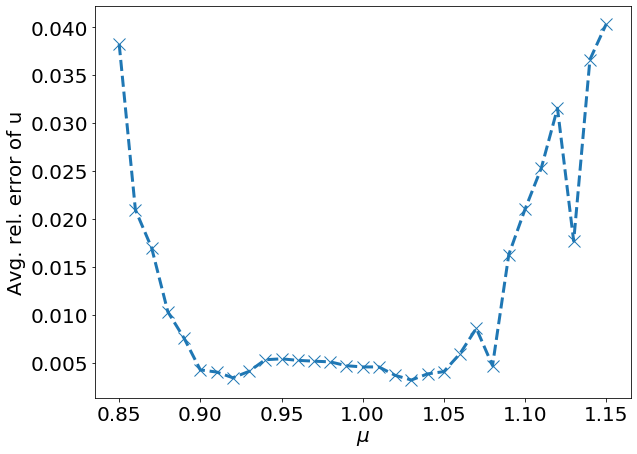

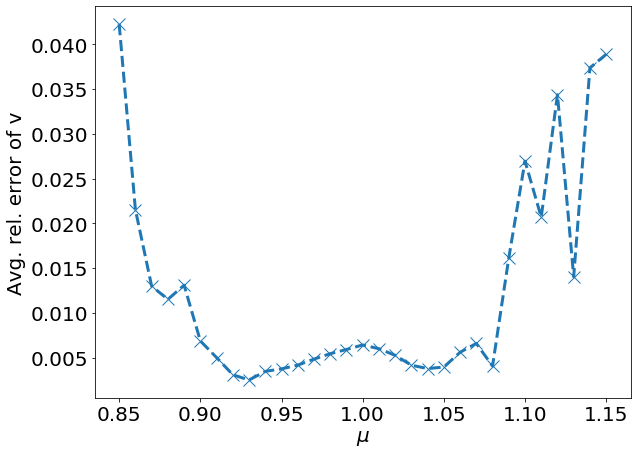

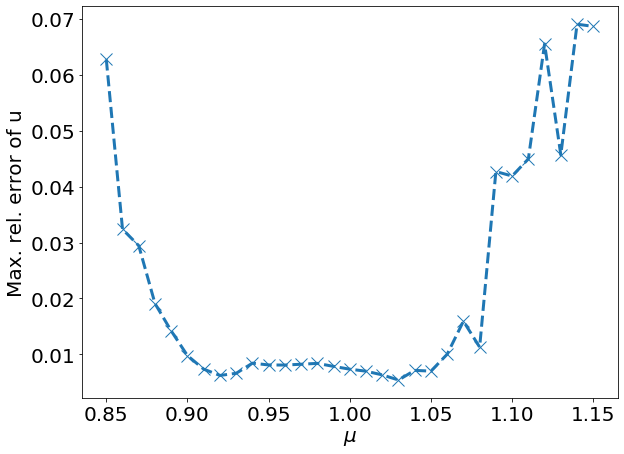

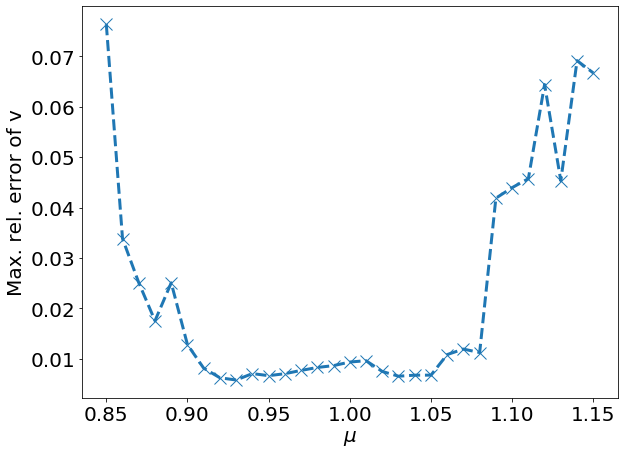

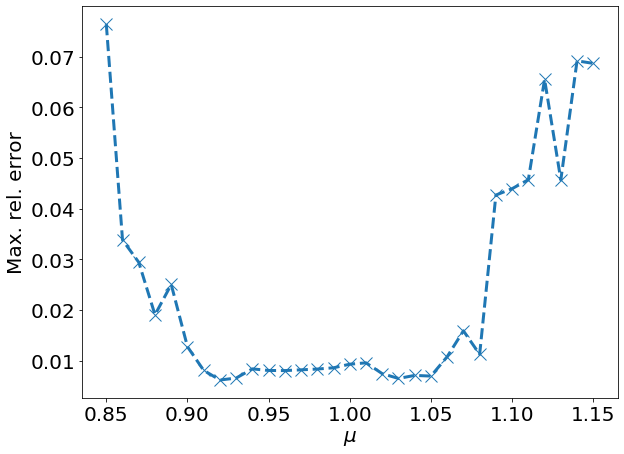

In [12]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(1.5*6.4, 1.5*4.8))
plt.plot(ampArr,1e-2*resultArr[:,-5],'x--',linewidth=3,markersize=12)
plt.xlabel(r'$\mu$')
plt.ylabel('Avg. rel. error of u')
plt.show()

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(1.5*6.4, 1.5*4.8))
plt.plot(ampArr,1e-2*resultArr[:,-4],'x--',linewidth=3,markersize=12)
plt.xlabel(r'$\mu$')
plt.ylabel('Avg. rel. error of v')
plt.show()

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(1.5*6.4, 1.5*4.8))
plt.plot(ampArr,1e-2*resultArr[:,-3],'x--',linewidth=3,markersize=12)
plt.xlabel(r'$\mu$')
plt.ylabel('Max. rel. error of u')
plt.show()

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(1.5*6.4, 1.5*4.8))
plt.plot(ampArr,1e-2*resultArr[:,-2],'x--',linewidth=3,markersize=12)
plt.xlabel(r'$\mu$')
plt.ylabel('Max. rel. error of v')
plt.show()

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(1.5*6.4, 1.5*4.8))
plt.plot(ampArr,1e-2*resultArr[:,-1],'x--',linewidth=3,markersize=12)
plt.xlabel(r'$\mu$')
plt.ylabel('Max. rel. error')
plt.show()

In [13]:
print('NM-LSPG-HR')
print()
ampArr= resultArr[:,0]
namp=ampArr.shape[0]
print('{:^6} {:^10} {:^10} {:^13} {:^13} {:^13} {:^13} {:^13} {:^13}'\
      .format('param','basis_dim','num_sample','time_elapsed','avg_rel_err_u','avg_rel_err_v','max_rel_err_u','max_rel_err_v','max_rel_err'))
for iii in range(namp):
    amp=ampArr[iii]
    basis_dim=int(resultArr[iii,1])
    num_sample=int(resultArr[iii,2])
    time_elapsed=resultArr[iii,3]
    avg_rel_err_u=resultArr[iii,4]
    avg_rel_err_v=resultArr[iii,5]
    max_rel_err_u=resultArr[iii,6]
    max_rel_err_v=resultArr[iii,7]
    max_rel_err=resultArr[iii,8]
    
    print('{:^6.2f} {:^10d} {:^10d} {:^13.2f} {:^13.2f} {:^13.2f} {:^13.2f} {:^13.2f} {:^13.2f}'\
          .format(amp,basis_dim,num_sample,time_elapsed,avg_rel_err_u,avg_rel_err_v,max_rel_err_u,max_rel_err_v,max_rel_err))

NM-LSPG-HR

param  basis_dim  num_sample time_elapsed  avg_rel_err_u avg_rel_err_v max_rel_err_u max_rel_err_v  max_rel_err 
 0.85      47         59         20.22         3.82          4.22          6.27          7.64          7.64     
 0.86      50         50         19.57         2.09          2.15          3.24          3.38          3.38     
 0.87      45         45         16.23         1.70          1.30          2.94          2.51          2.94     
 0.88      49         50         13.89         1.03          1.15          1.91          1.75          1.91     
 0.89      52         52         14.20         0.75          1.31          1.42          2.51          2.51     
 0.90      53         57         14.32         0.42          0.69          0.98          1.28          1.28     
 0.91      59         59         14.49         0.40          0.50          0.73          0.81          0.81     
 0.92      55         58         14.41         0.34          0.31          0.62     

# Save

In [14]:
pickle.dump(resultArr,open('./data/prediction_NM-LSPG-HR.p','wb'))
savemat('./data/prediction_NM-LSPG-HR.mat',{'resultArr':resultArr})